# Haplotype analysis *Coeaexf*

### Color palettes

In [1]:
# define dictionary of pop colors
pop_colours = {
 'Avrankou' : "sienna",
 'Korle-Bu' : "orange",
 'Baguida' : "skyblue",
 'Madina' : "cadetblue",
 'Obuasi' : "slateblue",
}

dup_colours = {
    'Dup present' : 'mediumorchid',
    'Dup absent' : 'lightgray',
}


### Import packages

In [2]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import re
import scipy.cluster
from scipy.stats import spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns



### Load CNV data

In [3]:
# Identify samples that have a Coeaexg CNV
disc_cnv_fn = '../Ag1000G_CNV_data/v3.2_1244-VO-GH-YAWSON-VMF00051/target_regions_analysis/focal_region_CNV_table.csv'
discordant_read_calls = pd.read_csv(disc_cnv_fn, sep = '\t', index_col = 0)
has_Dup = discordant_read_calls['Coeaexf_Dup1'].values
Dup_calls = has_Dup.astype('int')

# In order to known the copy number of each Dup specifically, we need to ignore samples that also
# have another CNV. 
other_coeaexf_cnvs = (
    discordant_read_calls.columns.str.contains('Coeaexf') &
    ~discordant_read_calls.columns.str.contains('Dup0') &
    ~discordant_read_calls.columns.str.contains('Dup1') 
)
other_coeaexf_calls = discordant_read_calls.loc[:, other_coeaexf_cnvs]
has_other_coeaexf_cnv = np.sum(other_coeaexf_calls, 1).values > 0

# Now we can exclude samples that have both the focal and another CNV allele, or that have the 
# allele and are of high coverage variance (because we won't be able to assign copy number correctly)
exclude_samples = (  
    has_Dup & (
        has_other_coeaexf_cnv | 
        discordant_read_calls["High.var.sample"]
    )                  
).values



### Load metadata

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

sample_sets = ['1244-VO-GH-YAWSON-VMF00051']
meta = ag3.sample_metadata(sample_sets = sample_sets).set_index('sample_id')
meta['location'] = meta['location'].str.replace('_.*', '', regex=True)

# Make sure the samples are in the same order as the CNV data (they should be anyway, but 
# just in case)
meta = meta.loc[discordant_read_calls.index, :]

# Get haplotype-level metadata
hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis = 0))
hap_meta.columns = meta.columns
hap_meta.index = [np.repeat(meta.index, 2)[i] + ['a', 'b'][i%2] for i in range(len(hap_meta))]

hap_meta_Dup = hap_meta.loc[~np.repeat(exclude_samples, 2), :]

hap_meta


,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,...,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter
VBS19051-5563STDY7800136a,WA-0001,Alexander Egyir-Yawson,Ghana,Madina,2017,11,5.683,-0.166,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,La-Nkwantanang-Madina,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_gamb_2017_Q4,GH-AA_La-Nkwantanang-Madina_gamb_2017,GH-AA_La-Nkwantanang-Madina_gamb_2017_11,GH-AA_La-Nkwantanang-Madina_gamb_2017_Q4
VBS19051-5563STDY7800136b,WA-0001,Alexander Egyir-Yawson,Ghana,Madina,2017,11,5.683,-0.166,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,La-Nkwantanang-Madina,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_gamb_2017_Q4,GH-AA_La-Nkwantanang-Madina_gamb_2017,GH-AA_La-Nkwantanang-Madina_gamb_2017_11,GH-AA_La-Nkwantanang-Madina_gamb_2017_Q4
VBS19052-5563STDY7800137a,WA-0002,Alexander Egyir-Yawson,Ghana,Madina,2017,11,5.683,-0.166,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,La-Nkwantanang-Madina,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_gamb_2017_Q4,GH-AA_La-Nkwantanang-Madina_gamb_2017,GH-AA_La-Nkwantanang-Madina_gamb_2017_11,GH-AA_La-Nkwantanang-Madina_gamb_2017_Q4
VBS19052-5563STDY7800137b,WA-0002,Alexander Egyir-Yawson,Ghana,Madina,2017,11,5.683,-0.166,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,La-Nkwantanang-Madina,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_gamb_2017_Q4,GH-AA_La-Nkwantanang-Madina_gamb_2017,GH-AA_La-Nkwantanang-Madina_gamb_2017_11,GH-AA_La-Nkwantanang-Madina_gamb_2017_Q4
VBS19053-5563STDY7800138a,WA-0003,Alexander Egyir-Yawson,Ghana,Madina,2017,11,5.683,-0.166,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,La-Nkwantanang-Madina,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_gamb_2017_Q4,GH-AA_La-Nkwantanang-Madina_gamb_2017,GH-AA_La-Nkwantanang-Madina_gamb_2017_11,GH-AA_La-Nkwantanang-Madina_gamb_2017_Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBS20013-5563STDY7801083b,WA-1333,Alexander Egyir-Yawson,Ghana,Korle-Bu,2018,2,5.537,-0.24,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,Ablekuma Central Municipal,coluzzii,GH-AA_colu_2018,GH-AA_colu_2018_02,GH-AA_colu_2018_Q1,GH-AA_Ablekuma-Central-Municipal_colu_2018,GH-AA_Ablekuma-Central-Municipal_colu_2018_02,GH-AA_Ablekuma-Central-Municipal_colu_2018_Q1
VBS20014-5563STDY7801084a,WA-1334,Alexander Egyir-Yawson,Ghana,Korle-Bu,2018,2,5.537,-0.24,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,Ablekuma Central Municipal,coluzzii,GH-AA_colu_2018,GH-AA_colu_2018_02,GH-AA_colu_2018_Q1,GH-AA_Ablekuma-Central-Municipal_colu_2018,GH-AA_Ablekuma-Central-Municipal_colu_2018_02,GH-AA_Ablekuma-Central-Municipal_colu_2018_Q1
VBS20014-5563STDY7801084b,WA-1334,Alexander Egyir-Yawson,Ghana,Korle-Bu,2018,2,5.537,-0.24,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,Ablekuma Central Municipal,coluzzii,GH-AA_colu_2018,GH-AA_colu_2018_02,GH-AA_colu_2018_Q1,GH-AA_Ablekuma-Central-Municipal_colu_2018,GH-AA_Ablekuma-Central-Municipal_colu_2018_02,GH-AA_Ablekuma-Central-Municipal_colu_2018_Q1
VBS20015-5563STDY7801085a,WA-1335,Alexander Egyir-Yawson,Ghana,Korle-Bu,2018,2,5.537,-0.24,F,1244-VO-GH-YAWSON-VMF00051,...,Greater Accra Region,GH-AA,Ablekuma Central Municipal,coluzzii,GH-AA_colu_2018,GH-AA_colu_2018_02,GH-AA_colu_2018_Q1,GH-AA_Ablekuma-Central-Municipal_colu_2018,GH-AA_Ablekuma-Central-Municipal_colu_2018_02,GH-AA_Ablekuma-Central-Municipal_colu_2018_Q1


In [5]:
gene_copy_number = pd.read_csv('../Ag1000G_CNV_data/v3.2_1244-VO-GH-YAWSON-VMF00051/modal_CNVs/modal_copy_number_gambcolu.csv', sep = '\t', index_col = 0)

# Define genes of interest
coeaexf_genes = dict(AGAP006227='Coeae1f')

# Select data for genes of interest, excluding samples with poor quality HMM data
coeae1f_gene_copy_number = (
    gene_copy_number.loc[:, coeaexf_genes.keys()]
    .rename(coeaexf_genes, axis='columns')
)['Coeae1f'].values

Dup_copy_number = coeae1f_gene_copy_number[~exclude_samples] * Dup_calls[~exclude_samples]

display(pd.crosstab(meta.loc[~exclude_samples, 'location'], Dup_copy_number))

col_0,0,3,4
location,,,
Korle-Bu,268,0,0
Madina,200,0,0
Obuasi,165,23,3


### Load the haplotype data

In [6]:
region='2L:28300000-28800000'

haps = (
    ag3.haplotypes(region = region, 
                   analysis = 'gamb_colu', 
                   sample_sets = sample_sets)
    .set_index(samples = 'sample_id')
    .sel(samples = discordant_read_calls.index)
)

haps_Dup = haps.isel(samples = ~exclude_samples)

In [7]:
# Create haplotype array
hap_array_Dup = allel.GenotypeArray(haps_Dup.call_genotype).to_haplotypes()

# Get allele counts
ac = hap_array_Dup.count_alleles()

# Identify segregating non-singletons. 
non_singleton = ac.min(1) > 1

# Filter the datasets, removing non-segregating and singleton variants 
haps_Dup = haps_Dup.isel(variants = np.where(non_singleton)[0])
hap_array_Dup = hap_array_Dup[non_singleton]

In [8]:
# Get the SNP genotypes coded as 0, 1, 2 (wt, het, homozygote mutant). Since all phased SNPs
# are biallelic, this is a suitable way to code genotype. 
genotypes = haps_Dup.call_genotype.values.sum(2)
genotypes

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 1, 2, 2],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0]])

### Identify proxy SNPs

In [9]:
# We look for SNPs whose presence / absence patterns are perfectly correlated with Dup0. 
SNP_cor = np.apply_along_axis(lambda x: spearmanr((x>0).astype('int'), 
                                                  Dup_calls[~exclude_samples]), 
                                    1, 
                                    genotypes)[:, 0]
SNP_cor = np.abs(SNP_cor)
print(f'The maximum correlation coefficient with the Dup is {np.nanmax(SNP_cor)}')


/tmp/ipykernel_161985/4191651924.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  SNP_cor = np.apply_along_axis(lambda x: spearmanr((x>0).astype('int'),


The maximum correlation coefficient with the Dup is 1.0


In [10]:
Dup_proxy = genotypes[np.nanargmax(SNP_cor)]

# Let's look at the association of zygosity at those SNPs and copy number. 
print('Association of Dup proxy zygosity and Dup copy number in An. gambiae:')
display(
    pd.crosstab(Dup_copy_number[(meta.loc[~exclude_samples, :].taxon == 'gambiae').values],
                Dup_proxy[(meta.loc[~exclude_samples, :].taxon == 'gambiae').values])
)




Association of Dup proxy zygosity and Dup copy number in An. gambiae:


col_0,0,1
row_0,,
0,365,0
3,0,23
4,0,3


In [11]:
print('Association of Dup proxy zygosity and Dup copy number overall:')
display(
    pd.crosstab(Dup_copy_number,
                Dup_proxy)
)

Association of Dup proxy zygosity and Dup copy number overall:


col_0,0,1
row_0,,
0,633,0
3,0,23
4,0,3


In [12]:
# Get the haplotypes rather than genotypes for the Dup proxy
Dup_hap_proxy = hap_array_Dup[np.nanargmax(SNP_cor)]
Dup_hap_proxy


array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

### Haplotype plotting functions

In [13]:
def find_clusters(dist, n, threshold=0.001, method='complete'):
        # build hierarchy
        clust = scipy.cluster.hierarchy.linkage(dist, method=method)
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(clust, threshold,
                                             criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        return clusters

# Some plotting functions
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

def plot_dendrogram(zhier, ax, h, method='complete', color_threshold=0, above_threshold_color='k'):

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(zhier, no_labels=True, count_sort=True,
                                           color_threshold=color_threshold,
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-.0001)

    ax.set_ylabel(r'$d_{xy}$')
    ax.autoscale(axis='x', tight=True)
    return r

def draw_hap_cluster_plot(z, r, h, 
                          pop_colour_scheme, cnv_colour_scheme, 
                          labels_for_pop_colours, labels_for_cnv_colours, 
                          cnv_name,
                          add_legend = True, title = '',
                          fn = None):

    gs = GridSpec(3, 1, height_ratios=[6.0, 0.5, 0.5])
    fig = plt.figure(figsize=(15, 5))

    plt.subplots_adjust(hspace=0.02)
    ax1 = plt.subplot(gs[0])
    sns.despine(ax=ax1, offset=5, bottom=True, top=True)
    _ = plot_dendrogram(z, ax1, h)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylim(0)

    ax_pops = fig.add_subplot(gs[1])

    x_pop = labels_for_pop_colours.take(r['leaves'])
    hap_pop_clrs = [pop_colour_scheme[p] for p in x_pop]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                        yrange=(0, 1),
                        color=hap_pop_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')
    
    ax_cnv = fig.add_subplot(gs[2])

    x_cnv = labels_for_cnv_colours.take(r['leaves'])
    hap_cnv_clrs = [cnv_colour_scheme[p] for p in x_cnv]
    ax_cnv.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                       yrange=(0, 1),
                       color=hap_cnv_clrs);
    sns.despine(ax=ax_cnv, offset=5, left=True, bottom=True, top=True)

    ax_cnv.set_xticks([])
    ax_cnv.set_yticks([])
    ax_cnv.set_xlim(0, h.shape[1])
    ax_cnv.yaxis.set_label_position('left')
    ax_cnv.set_ylabel(cnv_name, rotation=0, ha='right', va='center')

    if add_legend:
        plot_x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
        plot_y_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
        legend_x = ax1.get_xlim()[0] + plot_x_range * 0.95
            
        unique_label_cnv = np.unique(x_cnv)
        for i, k in enumerate(unique_label_cnv[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * i)
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = cnv_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)

        
        unique_label_pop = np.unique(x_pop)
        for j, k in enumerate(unique_label_pop[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * (i + 2 + j))
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = pop_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)



    ax1.set_title(f'{title}')
    ax1.autoscale()
    fig.patch.set_alpha(1)
    
    if fn != None:
        ext = re.sub('.*\.', '', fn)
        plt.savefig(fn, format = ext)




<>:123: SyntaxWarning: invalid escape sequence '\.'
<>:123: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_161985/1030769173.py:123: SyntaxWarning: invalid escape sequence '\.'
  ext = re.sub('.*\.', '', fn)


### Haplotype clustering

In [14]:
# Home in on the 500 SNPs around the region of interest
focal_pos = 28548072 # Middle of the two genes Coeae1f and Coeae2f
window_size = 500  # Measured in SNPs


In [15]:
hap_array_Dup

<HaplotypeArray shape=(32065, 1318) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 0 1 0 0 ... 0 1 0 0 0

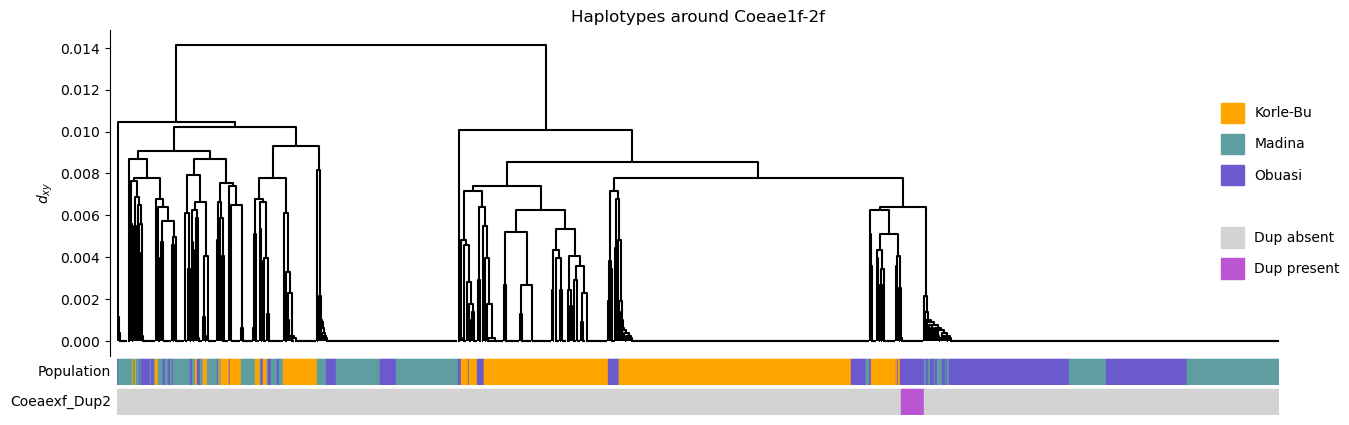

In [16]:
nearest_snp_index = np.argmin(np.abs(haps_Dup.variant_position - focal_pos).values)
haptree_region_indices = range(nearest_snp_index - window_size//2, nearest_snp_index + window_size//2)

haptree_region = '2L:' + '-'.join(haps_Dup.isel(variants = haptree_region_indices).variant_position.values[[0,-1]].astype('str'))
loc_hap = hap_array_Dup[haptree_region_indices]
# loc_hap is the haplotype array for just those 500 SNPs. 

# Calculate the distance matrix 
dist = allel.pairwise_distance(loc_hap, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region, sample_sets="3.2")['variant_filter_pass_gamb_colu']
n_bases = np.sum(site_filter.values)
dist_dxy = dist * loc_hap.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup_hap_status = np.array(['Dup absent', 'Dup present'])[Dup_hap_proxy]
draw_hap_cluster_plot(z, r, loc_hap, 
                      pop_colour_scheme = pop_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta_Dup['location'], 
                      labels_for_cnv_colours = Dup_hap_status, 
                      cnv_name = 'Coeaexf_Dup2',
                      title = 'Haplotypes around Coeae1f-2f',
                      fn = 'Coeaexf_haplotype_clustering.png'
)



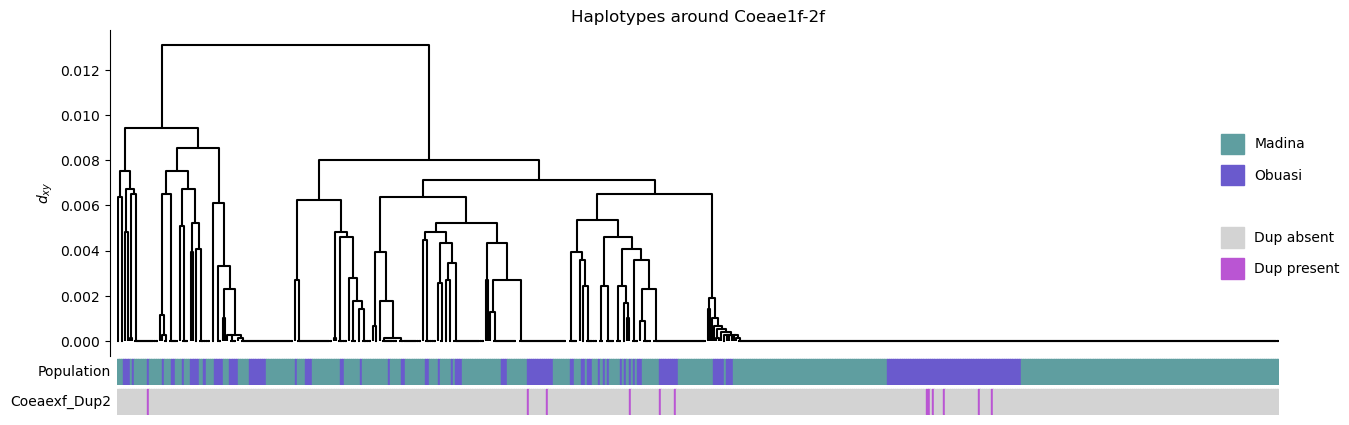

In [17]:
loc_hap = hap_array_Dup[haptree_region_indices, :][:, hap_meta_Dup.location == 'Korle-Bu']

# Calculate the distance matrix 
dist = allel.pairwise_distance(loc_hap, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region, sample_sets="3.2")['variant_filter_pass_gamb_colu']
n_bases = np.sum(site_filter.values)
dist_dxy = dist * loc_hap.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup_hap_status = np.array(['Dup absent', 'Dup present'])[Dup_hap_proxy][hap_meta_Dup.taxon == 'gambiae']
draw_hap_cluster_plot(z, r, loc_hap, 
                      pop_colour_scheme = pop_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta_Dup['location'][hap_meta_Dup.taxon == 'gambiae'], 
                      labels_for_cnv_colours = Dup_hap_status, 
                      cnv_name = 'Coeaexf_Dup2',
                      title = 'Haplotypes around Coeae1f-2f',
                      fn = 'Coeaexf_haplotype_clustering.png'
)

